In [ ]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix


# New section

In [ ]:
#Import Dataset
mnist_trainset= datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
X_train = mnist_trainset.data.view(-1, 1, 28, 28).float()
y_train = mnist_trainset.targets
X_test = mnist_testset.data.view(-1, 1, 28, 28).float()
y_test = mnist_testset.targets

100%|██████████| 9912422/9912422 [00:00<00:00, 83738091.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77800702.52it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31858575.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17771015.64it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#Checking number of test and training dataset
# print(mnist_trainset.shape)
print(len(mnist_testset))

10000


In [ ]:
#Normalization
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

In [ ]:
#OneHot Encoding
print(y_train.shape)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
#Define the One-hot Encoder
ohe = preprocessing.OneHotEncoder()
# Fit and transform training data
ohe.fit(y_train)
y_train = ohe.transform(y_train).toarray()

# Fit and transform testing data
ohe.fit(y_test)
y_test = ohe.transform(y_test).toarray()

# Print results
print('y shape',y_train.shape)
print(f'Value with encoding: {y_test[1]}')

torch.Size([60000])
torch.Size([60000, 1])
y shape (60000, 10)
Value with encoding: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


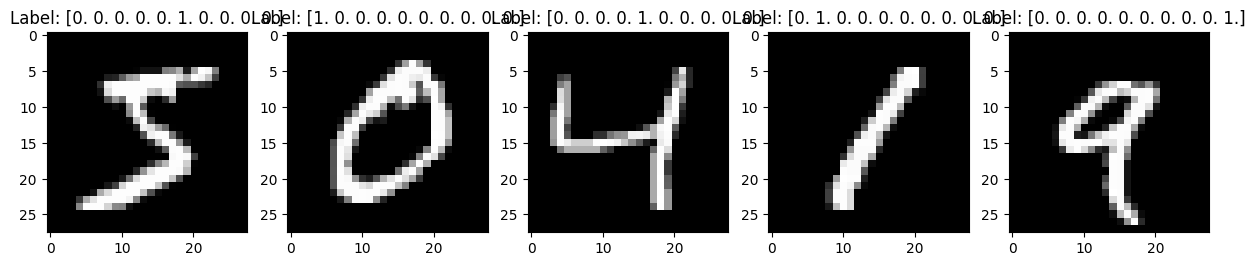

In [ ]:
#Image Visualization
num_images = 5
fig,axes = plt.subplots(1,num_images,figsize=(15,10))
for image,label,ax in zip(X_train[:num_images],y_train[:num_images],axes):
    ax.imshow(image.reshape(28,28),cmap='gray',vmin=0,vmax=1.0)
    ax.set_title(f"Label: {label}")

In [ ]:
# Flatten the training and testing data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Printing the shapes to verify
print("Flattened Training Data Shape:", X_train.shape)
print("Flattened Testing Data Shape:", X_test.shape)

Flattened Training Data Shape: torch.Size([60000, 784])
Flattened Testing Data Shape: torch.Size([10000, 784])


Defining a function which returns the activation function of our choice.

In [ ]:
def function(x,funct_name):
  if funct_name == 'sigmoid':
    return 1 / (1 + np.exp(-x))
  elif funct_name == 'tanh':
    return np.tanh(x)
  else :
    return np.maximum(0, x)


Derivative of the function of our choice

In [ ]:
def derivative(x,funct_name):
  if funct_name == 'sigmoid':
    return x * (1 - x)
  elif funct_name == 'tanh':
    return 1 - np.tanh(x)**2
  else :
    return np.where(x > 0, 1, 0)


In [ ]:
#Defining softmax activation
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return exp_x / exp_x.sum(axis=1, keepdims=True)
    #return np.exp(x) / np.sum(np.exp(x))

In [ ]:
def weight(n_input,n_output,function_name):
  if function_name == 'Glorot':
    M=np.sqrt(6/(n_input + n_output))
    weights = np.random.uniform(-M, M, size=(n_input, n_output))
  elif function_name == 'random':
    weights = np.random.randn(n_input,n_output)
  else:
    weights = np.zeros((n_input,n_output))
  return weights

In [ ]:

from random import seed
from random import random

class MLP:

  def __init__(self,input_size=784,layers=[500,250,100],output=10,learning_rate = 0.01,function_name='sigmoid',initialization='Glorot'):
    np.random.seed(0)
    layer ={}
    layer['w1'] = weight(input_size,layers[0], initialization )
    layer['w2'] = weight(layers[0],layers[1] ,initialization)
    layer['w3'] = weight(layers[1],layers[2] , initialization )
    layer['w4'] = weight(layers[2],output , initialization)

    layer['b1'] = np.zeros((1,layers[0]))
    layer['b2'] = np.zeros((1,layers[1]))
    layer['b3'] = np.zeros((1,layers[2]))
    layer['b4'] = np.zeros((1,10))
    print(layer['b1'].shape)

    self.initialization = initialization
    self.function_name = function_name
    self.learning_rate = learning_rate
    self.layer = layer
    self.activations = None
    self.loss = None
    self.input_size = input_size
    self.y_actual = None
    self.y = None
    self.deltas = None
    self.y_one_hot = None
    self.alpha = 0

  def forward_prop(self,input):
    z1 = np.dot(input, self.layer['w1']) + self.layer['b1']
    a1 = function(z1,self.function_name)

    z2 = np.dot(a1,self.layer['w2']) + self.layer['b2']
    a2 = function(z2,self.function_name)

    z3 = np.dot(a2,self.layer['w3']) + self.layer['b3']
    a3 = function(z3,self.function_name)

    z4 = np.dot(a3, self.layer['w4']) + self.layer['b4']
    y = softmax(z4)

    self.activations = [a1,a2,a3]
    self.y = y
    self.input = input

    return y

  def cal_loss(self,y_actual,y_pred):

    #  calculating the cross entropy loss function
    eps = 1e-15
    pred = np.clip(self.y, eps, 1 - eps)
    cross_entropy_loss = -np.sum(y_actual * np.log(pred)) / len(self.y)

    self.y_actual = y_actual
    self.loss = cross_entropy_loss
    self.y_one_hot = y_pred

    return cross_entropy_loss

  def accuracy(self):
    count = 0
    for i in range(len(self.y_one_hot)):
      y_actual_np = self.y_actual[i].numpy()
      if (self.y_one_hot[i] == y_actual_np).all():
        count += 1

    acc = count / len(self.y_one_hot)

    return count

  def backwardpass(self):

    delta5 = (self.y - np.array(self.y_actual))
    delta4 = (np.dot(delta5, self.layer['w4'].T) * derivative(self.activations[2],self.function_name))
    delta3 = (np.dot(delta4, self.layer['w3'].T) * derivative(self.activations[1],self.function_name))
    delta2 = (np.dot(delta3, self.layer['w2'].T) * derivative(self.activations[0],self.function_name))
    self.deltas = [delta2,delta3,delta4,delta5]

  def update_w_b(self):

    self.layer['w4'] = self.layer['w4'] - (self.learning_rate*(np.dot(self.activations[2].T, self.deltas[3])/len(self.y_actual) + (self.alpha * self.layer['w4'])/len(self.y_actual)))
    self.layer['w3'] = self.layer['w3'] - (self.learning_rate*(np.dot( self.activations[1].T, self.deltas[2])/len(self.y_actual) + (self.alpha * self.layer['w3'])/len(self.y_actual)))
    self.layer['w2'] = self.layer['w2'] - (self.learning_rate*(np.dot( self.activations[0].T,self.deltas[1])/len(self.y_actual) + (self.alpha * self.layer['w2'])/len(self.y_actual)))
    self.layer['w1'] = self.layer['w1'] - (self.learning_rate*(np.dot( self.input.T, self.deltas[0])/len(self.y_actual) + (self.alpha * self.layer['w1'])/len(self.y_actual)))

    self.layer['b4'] = self.layer['b4'] - (self.learning_rate*np.sum(self.deltas[3], axis=0, keepdims=True))/len(self.y_actual)
    self.layer['b3'] = self.layer['b3'] - (self.learning_rate*np.sum(self.deltas[2], axis=0, keepdims=True))/len(self.y_actual)
    self.layer['b2'] = self.layer['b2'] - (self.learning_rate*np.sum(self.deltas[1], axis=0, keepdims=True))/len(self.y_actual)
    self.layer['b1'] = self.layer['b1'] - (self.learning_rate*np.sum(self.deltas[0], axis=0, keepdims=True))/len(self.y_actual)





In [ ]:




def one_hot_encode(y):
  y_oht = np.zeros((y.shape[0],y.shape[1]))

  for i in range(y.shape[0]):
    # print(i)
    y_oht_temp = np.zeros(y.shape[1])
    # print(y_oht_temp.shape)
    max_index = np.argmax(y[i])
    y_oht_temp[max_index] = 1
    y_oht[i]= y_oht_temp
  # print("yoht",y_oht)
  return y_oht




In [ ]:

epochs =  15

mlp = MLP()
train_loss = []
test_loss=[]
count = 0
batch_size = 64
# for epoch in range(epochs):
#   for images, labels in train_dataset:
#     mlp.forward_prop(images)
#     train_loss.append(mlp.cal_loss(labels))
#     mlp.backwardpass()
#     mlp.update_w_b()

for epoch in range(epochs):
  iteration = 0
  for i in range(0,len(X_train),batch_size):
    x_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
  # for images, labels in train_dataset:

    output = mlp.forward_prop(x_batch)
    output_hot = one_hot_encode(output)

    loss = mlp.cal_loss(y_batch,output_hot)
    mlp.backwardpass()
    mlp.update_w_b()

    # count = count + mlp.accuracy()

    if iteration % 200 == 0:
      train_loss.append(mlp.cal_loss(y_batch,output_hot))

    iteration += 1  # Increment the iteration count

    # print("accuracy of batch % = ", (mlp.accuracy()/64)*100)
  print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
  # print(f'Accuracy: {(count * 100)/60000:.2f}%')


# After training, plot the losses
iterations = np.arange(0, len(train_loss) * 200, 200)  # X-axis values (iterations)

# plt.figure(figsize=(10, 5))
# plt.plot(iterations, test_loss)
# plt.plot(np.arange(0, len(train_loss) * 200, 200), train_loss, label='Train Loss', linestyle='--')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss vs number of iterations')
# plt.show()

def test(x):

  output = mlp.forward_prop(x)
  return np.argmax(output, axis=1)

y_pred = test(X_train)
accuracy = np.mean(np.argmax(y_train, axis=1) == y_pred)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

confusion_matrix_result = confusion_matrix(np.argmax(y_train, axis=1), y_pred)
print(confusion_matrix_result)











(1, 500)
Epoch 1/15, Loss: 2.2993
Epoch 2/15, Loss: 2.2862
Epoch 3/15, Loss: 2.2678
Epoch 4/15, Loss: 2.2371
Epoch 5/15, Loss: 2.1771
Epoch 6/15, Loss: 2.0428
Epoch 7/15, Loss: 1.7921
Epoch 8/15, Loss: 1.4800
Epoch 9/15, Loss: 1.1984
Epoch 10/15, Loss: 0.9664
Epoch 11/15, Loss: 0.7839
Epoch 12/15, Loss: 0.6550
Epoch 13/15, Loss: 0.5648
Epoch 14/15, Loss: 0.4993
Epoch 15/15, Loss: 0.4507
Train Accuracy: 83.27%
[[5572    1   33   17   18  195   48    6   30    3]
 [   0 6539   39   30    0   22    1   15   81   15]
 [  95  155 4814  283  173   39  196   74  104   25]
 [  28  118  181 4878    5  388   16  123  347   47]
 [  14   50   23    0 4672    7  137    5   40  894]
 [  94   41  103  529   98 3840  208   86  303  119]
 [  83   37  133    0  116   94 5362    0   93    0]
 [  34  213   44   12   33   20    0 5424   28  457]
 [  25  322  105  398  105  238  117   17 4296  228]
 [  54   70   27   64  679   52   12  377   52 4562]]


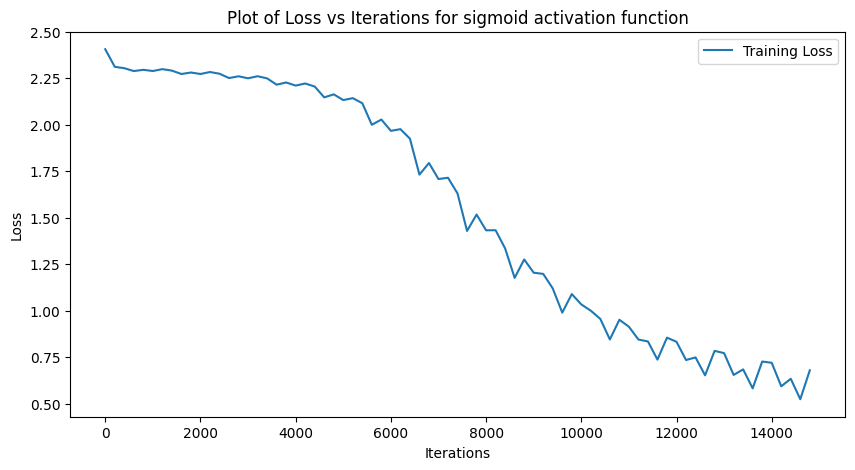

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
train_loss_tensor = torch.tensor(train_loss, dtype=torch.float32)
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss_tensor.numpy(), label='Training Loss')
# plt.plot(np.arange(0, len(train_loss) * 200, 200), train_loss_tensor.numpy(), label='Test Loss', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Plot of Loss vs Iterations for sigmoid activation function')
plt.show()

In [ ]:
def test(x):

  output = mlp.forward_prop(X_test)
  return np.argmax(output, axis=1)

y_pred = test(X_test)
accuracy = np.mean(np.argmax(y_test, axis=1) == y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 83.87%


In [ ]:
 def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

MLP using ADAM optimizer


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
learning_rate = 0.01
batch_size = 64
epochs = 15

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.z1 = nn.Linear(28 * 28, 500)
        self.z2 = nn.Linear(500, 250)
        self.z3 = nn.Linear(250, 100)
        self.z4 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.z1(x))
        x = torch.sigmoid(self.z2(x))
        x = torch.sigmoid(self.z3(x))
        x = self.z4(x)
        return x

model = NeuralNetwork()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_history.append(running_loss / len(train_loader))

    print(f'Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / len(train_loader):.4f}')


Epoch [1/15] Loss: 0.3100
Epoch [2/15] Loss: 0.1205
Epoch [3/15] Loss: 0.0996
Epoch [4/15] Loss: 0.0833
Epoch [5/15] Loss: 0.0805
Epoch [6/15] Loss: 0.0732
Epoch [7/15] Loss: 0.0721
Epoch [8/15] Loss: 0.0680
Epoch [9/15] Loss: 0.0697
Epoch [10/15] Loss: 0.0650
Epoch [11/15] Loss: 0.0633
Epoch [12/15] Loss: 0.0657
Epoch [13/15] Loss: 0.0618
Epoch [14/15] Loss: 0.0607
Epoch [15/15] Loss: 0.0571


In [ ]:
model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Calculate and Display Classification Report
target_names = [str(i) for i in range(10)]  # Assuming you have 10 classes
print(classification_report(all_labels, all_predicted, target_names=target_names))

# Calculate and Display Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 97.18%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.94      0.99      0.96       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:
[[ 961    0    2    0    5    4    4    1    2    1]
 [   0 1126    1    1    2    1    3    0    1    0]
 [   2    2 1012    0    5    2    3    3    3    0]
 [   0    6   12  974    2    5    0    3 

************************************************
